# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

D:\anacondaz\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\anacondaz\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\anacondaz\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=200)

[871756,
 1106523,
 1044078,
 844179,
 899624,
 832678,
 8090537,
 1000753,
 12262978,
 965267,
 5569230,
 1081177,
 5585510,
 999714,
 8090521,
 863447,
 1022428,
 835300,
 925862,
 947858,
 883932,
 854852,
 823990,
 1046545,
 1004906,
 865456,
 963727,
 850102,
 841220,
 896613,
 12301839,
 944534,
 865528,
 8090509,
 1051323,
 835530,
 903609,
 1025535,
 1037863,
 857006,
 1029743,
 1116376,
 866211,
 6534480,
 5569845,
 847962,
 828106,
 930283,
 1068292,
 9835223,
 1132771,
 847790,
 6534077,
 861279,
 998239,
 1100972,
 1107420,
 880150,
 8090539,
 9836106,
 1123146,
 5568378,
 999779,
 1070702,
 1062572,
 845208,
 952163,
 1134678,
 1003616,
 823704,
 1090931,
 989069,
 836445,
 6463729,
 895166,
 12262778,
 9835606,
 878996,
 965766,
 12302069,
 972143,
 1059473,
 910032,
 1037337,
 986912,
 879504,
 1004390,
 1103691,
 977658,
 858514,
 1097458,
 1104349,
 5568197,
 1065860,
 15926886,
 1082185,
 1068719,
 850925,
 993638,
 1021324,
 874972,
 8065410,
 1102207,
 5570048,
 111

In [6]:
recommender.get_own_recommendations(2375, N=200)

[948640,
 918046,
 847962,
 907099,
 873980,
 884694,
 10285454,
 1107760,
 7169090,
 979674,
 10308345,
 1069531,
 974766,
 1015474,
 950935,
 847066,
 1102207,
 1020770,
 9521787,
 974265,
 940996,
 8019845,
 5567194,
 12811490,
 1003616,
 973181,
 890719,
 982955,
 9677152,
 998519,
 1072685,
 1131382,
 1021715,
 12263119,
 960791,
 7441873,
 986021,
 956666,
 1038692,
 9677748,
 9297223,
 927030,
 12757653,
 1046919,
 6391532,
 989069,
 1068451,
 951954,
 835300,
 937343,
 1047249,
 13876348,
 1061732,
 981601,
 1121028,
 1087547,
 828393,
 996269,
 951951,
 1036093,
 1023815,
 5570408,
 827667,
 1082454,
 1006878,
 5570048,
 841309,
 1078652,
 1115553,
 1056492,
 1138467,
 1004945,
 947858,
 1092885,
 1121694,
 938138,
 8019916,
 827919,
 984315,
 10341855,
 883932,
 8291322,
 1096794,
 1028938,
 1087618,
 8020166,
 1082185,
 866871,
 930666,
 825994,
 910151,
 823990,
 848029,
 896613,
 12301839,
 1117219,
 1135258,
 869868,
 1046545,
 899624,
 6442594,
 1137775,
 825343,
 104290

In [7]:
recommender.get_similar_items_recommendation(2375, N=200)

[1046545,
 1044078,
 1044078,
 6552253,
 965766,
 999999,
 972191,
 896613,
 885863,
 1025535,
 899624,
 878996,
 906923,
 871611,
 865528,
 919681,
 828106,
 1040807,
 1127831,
 921763,
 938138,
 847207,
 858373,
 12301100,
 899624,
 884945,
 827578,
 878285,
 985999,
 7441191,
 9835903,
 1068719,
 1000753,
 8205418,
 1069312,
 1087102,
 918994,
 825343,
 1018316,
 8068648,
 835922,
 916122,
 869322,
 820347,
 1065538,
 12648296,
 947201,
 822178,
 8065410,
 1008032,
 1000050,
 960732,
 1065129,
 990797,
 825731,
 1002771,
 865456,
 828106,
 883068,
 1105488,
 1138467,
 848029,
 1120559,
 930118,
 899459,
 10308345,
 1022428,
 882247,
 5568378,
 948650,
 977882,
 12262778,
 9420314,
 860106,
 7441191,
 969945,
 866025,
 5591170,
 5568721,
 7167864,
 999270,
 12301109,
 999858,
 5565202,
 9297055,
 9527160,
 9677149,
 9297106,
 997987,
 1020823,
 1079338,
 12757425,
 963354,
 835783,
 1048507,
 856827,
 1072519,
 937292,
 1028995,
 860804,
 868909,
 1087102,
 1110857,
 909811,
 1055155

In [8]:
recommender.get_similar_users_recommendation(2375, N=200)

[7146026,
 1057749,
 938165,
 1133654,
 1115069,
 8090956,
 13002975,
 1056212,
 1107760,
 955275,
 821741,
 993838,
 1138596,
 835351,
 1123106,
 918638,
 841236,
 977559,
 900379,
 841365,
 847962,
 970152,
 1056212,
 928749,
 8203710,
 1029549,
 870515,
 1055403,
 1115069,
 949257,
 918638,
 879734,
 865026,
 819840,
 875392,
 979674,
 970160,
 1138596,
 1082990,
 7442505,
 962967,
 847962,
 1037135,
 861494,
 1135971,
 820486,
 1132956,
 1057168,
 1097398,
 9420354,
 1055403,
 1122844,
 6979393,
 1117690,
 1008288,
 917406,
 8090956,
 998519,
 1111986,
 1134006,
 949257,
 1081533,
 1056212,
 950935,
 1075765,
 1115069,
 1024319,
 1136341,
 1062572,
 1052294,
 874563,
 971474,
 1113675,
 1070129,
 1134296,
 1052975,
 825317,
 928749,
 1088771,
 873324,
 820486,
 928749,
 1096573,
 949345,
 1038745,
 918046,
 8090542,
 907099,
 953539,
 1065259,
 835499,
 1096573,
 970152,
 879922,
 1069039,
 5574377,
 1049922,
 847962,
 958067,
 9677462,
 1087411,
 872066,
 1069256,
 983959,
 102448

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
data_val_lvl_1=data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1.user_id.unique().tolist())]

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
# your_code
result_lvl_1['als']=result_lvl_1['user_id'].apply(lambda x:recommender.get_als_recommendations(x, N=200))

result_lvl_1['own']=result_lvl_1['user_id'].apply(lambda x:recommender.get_own_recommendations(x, N=200))

result_lvl_1['sim_items']=result_lvl_1['user_id'].apply(lambda x:recommender.get_similar_items_recommendation(x, N=200))

In [12]:
# result_lvl_1['sim_users']=result_lvl_1['user_id'].apply(lambda x:recommender.get_similar_users_recommendation(x, N=200))

In [13]:
result_lvl_1['recall_als']=result_lvl_1.apply(lambda x:recall_at_k(x['als'],x['actual'],k=20),axis=1)
result_lvl_1['recall_own']=result_lvl_1.apply(lambda x:recall_at_k(x['own'],x['actual'],k=20),axis=1)
result_lvl_1['recall_sim_items']=result_lvl_1.apply(lambda x:recall_at_k(x['sim_items'],x['actual'],k=20),axis=1)

In [14]:
for n in ['recall_als','recall_own','recall_sim_items']:
    print(f'Результат {n} : {result_lvl_1[n].mean()}')

Результат recall_als : 0.02866260352933246
Результат recall_own : 0.03928427679372909
Результат recall_sim_items : 0.017732079808632062


***recall_own показал наилучший результат***

In [17]:
import seaborn as sns

In [48]:
sns.set(rc={'figure.figsize':(10,5)})

In [25]:
df_mtr=pd.DataFrame()
for k in [20, 50, 100, 200, 500]:
    c=result_lvl_1.apply(lambda x:recall_at_k(x['own'],x['actual'],k=k),axis=1).mean()
    df_temp=pd.DataFrame({'at_k':[k],'value':[c]})
    df_mtr=df_mtr.append(df_temp)

Text(0.5, 1.0, 'Зависимость значение recall_at_k от количество k')

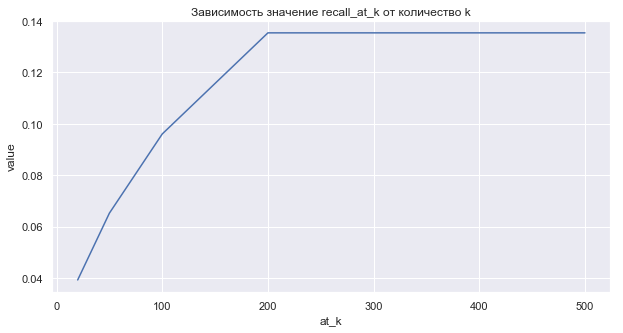

In [49]:
sns.lineplot(x='at_k',y='value',data=df_mtr).set_title('Зависимость значение recall_at_k от количество k')

Наиболее разумным лучше подбирать k в соотстветствии c бизнесой задачей. Например, нужно порекомендовать 10 товаров, то лучше в финальной метрике делать recall на 10 товаров

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [68]:
data_val_lvl_2=data_val_lvl_2[data_val_lvl_2['user_id'].isin(data_train_lvl_1.user_id.unique().tolist())]

In [69]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [70]:
result_lvl_2['own']=result_lvl_2['user_id'].apply(lambda x:recommender.get_own_recommendations(x, N=200))

precision@5 модели 1-ого уровня

In [71]:
result_lvl_2.apply(lambda x:precision_at_k(x['own'],x['actual'],k=5),axis=1).mean()

0.1507049608355081

In [51]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [52]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [53]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная пересенная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [54]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

Добавление фичей

In [56]:
targets_lvl_2 = targets_lvl_2.merge(item_features[['item_id','brand','sub_commodity_desc']], on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features[['user_id','household_size_desc','marital_status_code']], on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,brand,sub_commodity_desc,household_size_desc,marital_status_code
0,2070,1105426,0.0,Private,SANDWICHES - (COLD),1,U
1,2070,1097350,0.0,National,VALUE GLASS WINE,1,U


In [57]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [59]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['brand', 'sub_commodity_desc', 'household_size_desc', 'marital_status_code']

Обучение

In [60]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\Zviad\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Zviad\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Zviad\AppData\Roaming\Python\Python37\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Wall time: 20.6 s


In [61]:
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [72]:
# На всякий чтобы не потерять датафрейм
X_train_c=X_train

In [73]:
X_train_c['pred']=pd.DataFrame(train_preds)

In [75]:
X_train_c=X_train_c[X_train_c['pred']==1]

In [78]:
data_check = X_train_c.groupby('user_id')['item_id'].unique().reset_index()
data_check.columns=['user_id', 'pred_lgbm']
data_check.head(2)

,user_id,pred_lgbm
0,1,"[1029743, 1070820]"
1,7,"[1029743, 1070820]"


In [81]:
data_check_=data_check.merge(result_lvl_2[['user_id','actual']],how='left',on='user_id')

In [83]:
data_check_.head()

,user_id,pred_lgbm,actual
0,1,"[1029743, 1070820]","[821867, 834484, 856942, 865456, 889248, 90795..."
1,7,"[1029743, 1070820]","[840386, 889774, 898068, 909714, 929067, 95347..."
2,13,"[9488065, 865156, 10456568, 951197, 7168417]","[6534178, 1104146, 829197, 840361, 862070, 884..."
3,16,[1082185],"[1062973, 1082185, 13007710]"
4,18,"[1029743, 1106523, 1126899, 1070820]","[831628, 907877, 914697, 995242, 1118878, 1128..."


precision@5 модели 2-ого уровня

In [84]:
data_check_.apply(lambda x:precision_at_k(x['pred_lgbm'],x['actual'],k=5),axis=1).mean()

0.29197368421052633

Можно сказать, что на 2-х уровненвой модели метрика улучшилась

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)